In [1]:
from loadTestCases import load

In [87]:
import os
import sys
import numpy as np
import math
from scipy.signal import get_window
import matplotlib.pyplot as plt

sys.path.append('../../software/models/')
import utilFunctions as UF
import harmonicModel as HM
import sineModel as SM
import stft

eps = np.finfo(float).eps

"""
A6Part1 - Estimate fundamental frequency in polyphonic audio signal

Set the analysis parameters used within the function estimateF0() to obtain a good estimate of the 
fundamental frequency (f0) corresponding to one melody within a complex audio signal. The signal 
is a cello recording cello-double-2.wav, in which two strings are played simultaneously. One string 
plays a constant drone while the other string plays a simple melody. You have to choose the analysis 
parameter values such that only the f0 frequency of the simple melody is tracked.

The input argument to the function is the wav file name including the path (inputFile). The function 
returns a numpy array of the f0 frequency values for each audio frame. For this question we take 
hopSize (H) = 256 samples. 

estimateF0() calls f0Detection() function of the harmonicModel.py, which uses the two way mismatch 
algorithm for f0 estimation. 

estimateF0() also plots the f0 contour on top of the spectrogram of the audio signal for you to 
visually analyse the performance of your chosen values for the analysis parameters. In this question 
we will only focus on the time segment between 0.5 and 4 seconds. So, your analysis parameter values 
should produce a good f0 contour in this time region.

In addition to plotting the f0 contour on the spectrogram, this function also synthesizes the f0 
contour. You can also evaluate the performance of your chosen analysis parameter values by listening 
to this synthesized wav file named 'synthF0Contour.wav'

Since there can be numerous combinations of the optimal analysis parameter values, the evaluation is 
done solely on the basis of the output f0 sequence. Note that only the segment of the f0 contour 
between time 0.5 to 4 seconds is used to evaluate the performance of f0 estimation.

Your assignment will be tested only on inputFile = '../../sounds/cello-double-2.wav'. So choose the 
analysis parameters using which the function estimates the f0 frequency contour corresponding to the 
string playing simple melody and not the drone. There is no separate test case for this question. 
You can keep working with the wav file mentioned above and when you think the performance is 
satisfactory you can submit the assignment. The plots can help you achieve a good performance. 

Be cautious while choosing the window size. Window size should be large enough to resolve the spectral 
peaks and small enough to preserve the note transitions. Very large window sizes may smear the f0 
contour at note transitions.

Depending on the parameters you choose and the capabilities of the hardware you use, the function 
might take a while to run (even half a minute in some cases). For this part of the assignment please 
refrain from posting your analysis parameters on the discussion forum. 
"""
def estimateF0(inputFile = '../../sounds/cello-double-2.wav'):
    """
    Function to estimate fundamental frequency (f0) in an audio signal. This function also plots the 
    f0 contour on the spectrogram and synthesize the f0 contour.
    Input:
        inputFile (string): wav file including the path
    Output:
        f0 (numpy array): array of the estimated fundamental frequency (f0) values
    """

    ### Change these analysis parameter values marked as XX
    window = 'blackman'
    M = 2701
    N = 4096
    f0et = 10
    t = -80
    minf0 = 120
    maxf0 = 210

    ### Do not modify the code below 
    H = 256                                                     #fix hop size
      
    fs, x = UF.wavread(inputFile)                               #reading inputFile
    w  = get_window(window, M)                                  #obtaining analysis window    
    
    ### Method 1
    f0 = HM.f0Detection(x, fs, w, N, H, t, minf0, maxf0, f0et)  #estimating F0
    startFrame = int(np.floor(0.5*fs/H))
    endFrame = int(np.ceil(4.0*fs/H))
    f0[:startFrame] = 0
    f0[endFrame:] = 0
    y = UF.sinewaveSynth(f0, 0.8, H, fs)
    UF.wavwrite(y, fs, 'synthF0Contour.wav')

    ## Code for plotting the f0 contour on top of the spectrogram
    # frequency range to plot
    maxplotfreq = 500.0    
    fontSize = 16
    plot = 1

    fig = plt.figure()
    ax = fig.add_subplot(111)

    mX, pX = stft.stftAnal(x, w, N, H)                      #using same params as used for analysis
    mX = np.transpose(mX[:,:int(N*(maxplotfreq/fs))+1])
    
    timeStamps = np.arange(mX.shape[1])*H/float(fs)                             
    binFreqs = np.arange(mX.shape[0])*fs/float(N)
    
    plt.pcolormesh(timeStamps, binFreqs, mX)
    plt.plot(timeStamps, f0, color = 'k', linewidth=1.5)
    plt.plot([0.5, 0.5], [0, maxplotfreq], color = 'b', linewidth=1.5)
    plt.plot([4.0, 4.0], [0, maxplotfreq], color = 'b', linewidth=1.5)
    
    
    plt.autoscale(tight=True)
    plt.ylabel('Frequency (Hz)', fontsize = fontSize)
    plt.xlabel('Time (s)', fontsize = fontSize)
    plt.legend(('f0',))
    
    xLim = ax.get_xlim()
    yLim = ax.get_ylim()
    ax.set_aspect((xLim[1]-xLim[0])/(2.0*(yLim[1]-yLim[0])))    

    if plot == 1: #save the plot too!
        plt.autoscale(tight=True) 
        plt.show()
    else:
        fig.tight_layout()
        fig.savefig('f0_over_Spectrogram.png', dpi=150, bbox_inches='tight')

    return f0


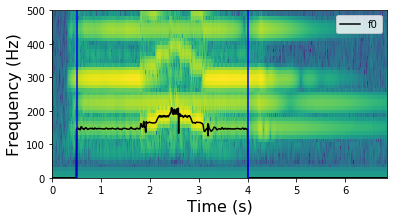

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [88]:
estimateF0()

In [242]:
import os
import sys
import numpy as np
import math
from scipy.signal import get_window
import matplotlib.pyplot as plt

sys.path.append('../../software/models/')
import utilFunctions as UF
import harmonicModel as HM
import stft

eps = np.finfo(float).eps

"""
A6Part2 - Segmentation of stable note regions in an audio signal

Complete the function segmentStableNotesRegions() to identify the stable regions of notes in a specific 
monophonic audio signal. The function returns an array of segments where each segment contains the 
starting and the ending frame index of a stable note.

The input argument to the function are the wav file name including the path (inputFile), threshold to 
be used for deciding stable notes (stdThsld) in cents, minimum allowed duration of a stable note (minNoteDur), 
number of samples to be considered for computing standard deviation (winStable), analysis window (window), 
window size (M), FFT size (N), hop size (H), error threshold used in the f0 detection (f0et), magnitude 
threshold for spectral peak picking (t), minimum allowed f0 (minf0) and maximum allowed f0 (maxf0). 
The function returns a numpy array of shape (k,2), where k is the total number of detected segments. 
The two columns in each row contains the starting and the ending frame indexes of a stable note segment. 
The segments must be returned in the increasing order of their start times. 

In order to facilitate the assignment we have configured the input parameters to work with a particular 
sound, '../../sounds/sax-phrase-short.wav'. The code and parameters to estimate the fundamental frequency 
is completed. Thus you start from an f0 curve obtained using the f0Detection() function and you will use 
that to obtain the note segments. 

All the steps to be implemented in order to solve this question are indicated in segmentStableNotesRegions() 
as comments. These are the steps:

1. In order to make the processing musically relevant, the f0 values should be converted first from 
Hertz to Cents, which is a logarithmic scale. 
2. At each time frame (for each f0 value) you should compute the standard deviation of the past winStable 
number of f0 samples (including the f0 sample at the current audio frame). 
3. You should then apply a deviation threshold, stdThsld, to determine if the current frame belongs 
to a stable note region or not. Since we are interested in the stable note regions, the standard 
deviation of the previous winStable number of f0 samples (including the current sample) should be less 
than stdThsld i.e. use the current sample and winStable-1 previous samples. Ignore the first winStable-1 
samples in this computation.
4. All the consecutive frames belonging to the stable note regions should be grouped together into 
segments. For example, if the indexes of the frames corresponding to the stable note regions are 
3,4,5,6,12,13,14, we get two segments, first 3-6 and second 12-14. 
5. After grouping frame indexes into segments filter/remove the segments which are smaller in duration 
than minNoteDur. Return the segment indexes in the increasing order of their start frame index.
                              
Test case 1: Using inputFile='../../sounds/cello-phrase.wav', stdThsld=10, minNoteDur=0.1, 
winStable = 3, window='hamming', M=1025, N=2048, H=256, f0et=5.0, t=-100, minf0=310, maxf0=650, 
the function segmentStableNotesRegions() should return 9 segments. Please use loadTestcases.load() 
to check the expected segment indexes in the output.

Test case 2: Using inputFile='../../sounds/cello-phrase.wav', stdThsld=20, minNoteDur=0.5, 
winStable = 3, window='hamming', M=1025, N=2048, H=256, f0et=5.0, t=-100, minf0=310, maxf0=650, 
the function segmentStableNotesRegions() should return 6 segments. Please use loadTestcases.load() 
to check the expected segment indexes in the output.

Test case 3: Using inputFile='../../sounds/sax-phrase-short.wav', stdThsld=5, minNoteDur=0.6, 
winStable = 3, window='hamming', M=1025, N=2048, H=256, f0et=5.0, t=-100, minf0=310, maxf0=650, 
the function segmentStableNotesRegions() should return just one segment. Please use loadTestcases.load() 
to check the expected segment indexes in the output. 

We also provide the function plotSpectogramF0Segments() to plot the f0 contour and the detected 
segments on the top of the spectrogram of the audio signal in order to visually analyse the outcome 
of your function. Depending on the analysis parameters and the capabilities of the hardware you 
use, the function might take a while to run (even half a minute in some cases). 

"""

def segmentStableNotesRegions(inputFile = '../../sounds/sax-phrase-short.wav', stdThsld=10, minNoteDur=0.1, 
                              winStable = 3, window='hamming', M=1024, N=2048, H=256, f0et=5.0, t=-100, 
                              minf0=310, maxf0=650):
    """
    Function to segment the stable note regions in an audio signal
    Input:
        inputFile (string): wav file including the path
        stdThsld (float): threshold for detecting stable regions in the f0 contour (in cents)
        minNoteDur (float): minimum allowed segment length (note duration)  
        winStable (integer): number of samples used for computing standard deviation
        window (string): analysis window
        M (integer): window size used for computing f0 contour
        N (integer): FFT size used for computing f0 contour
        H (integer): Hop size used for computing f0 contour
        f0et (float): error threshold used for the f0 computation
        t (float): magnitude threshold in dB used in spectral peak picking
        minf0 (float): minimum fundamental frequency in Hz
        maxf0 (float): maximum fundamental frequency in Hz
    Output:
        segments (np.ndarray): Numpy array containing starting and ending frame indexes of every segment.
    """
    fs, x = UF.wavread(inputFile)                               #reading inputFile
    w  = get_window(window, M)                                  #obtaining analysis window    
    f0 = HM.f0Detection(x, fs, w, N, H, t, minf0, maxf0, f0et)  #estimating F0

    ### your code here

    # 1. convert f0 values from Hz to Cents (as described in pdf document)
    f0[f0 == 0] = eps
    f0_cents = 1200*np.log2(f0/55)

    #2. create an array containing standard deviation of last winStable samples
    stds = []
    for i in range(len(f0_cents)):
        if i < winStable:
            std = stdThsld + 1
        else:
            std = np.std(f0_cents[i - (winStable - 1):i + 1])
        stds.append(std)
    stds = np.array(stds)
    
    #3. apply threshold on standard deviation values to find indexes of the stable points in melody
    stable = np.where(stds < stdThsld + eps)[0]

    #4. create segments of continuous stable points such that consecutive stable points belong to same segment
    segments = []
    last_stable_index = 0
    last_seen = 0
    for i in stable:
        if i - 1 > last_seen:
            segments.append((last_stable_index, last_seen))
            last_stable_index = i
        last_seen = i
    if last_seen - 1 == stable[-2]:
        segments.append((last_stable_index, last_seen))
    
    #5. apply segment filtering, i.e. remove segments with are < minNoteDur in length
    segments = list(filter(lambda x: ((x[1] - x[0]) * H) / fs >= minNoteDur, segments))
    segments = np.array(segments)
         
#     plotSpectogramF0Segments(x, fs, w, N, H, f0, segments)  # Plot spectrogram and F0 if needed

    return segments


def plotSpectogramF0Segments(x, fs, w, N, H, f0, segments):
    """
    Code for plotting the f0 contour on top of the spectrogram
    """
    # frequency range to plot
    maxplotfreq = 1000.0    
    fontSize = 16

    fig = plt.figure()
    ax = fig.add_subplot(111)

    mX, pX = stft.stftAnal(x, w, N, H)                      #using same params as used for analysis
    mX = np.transpose(mX[:,:int(N*(maxplotfreq/fs))+1])
    
    timeStamps = np.arange(mX.shape[1])*H/float(fs)                             
    binFreqs = np.arange(mX.shape[0])*fs/float(N)
    
    plt.pcolormesh(timeStamps, binFreqs, mX)
    plt.plot(timeStamps, f0, color = 'k', linewidth=5)

    for ii in range(segments.shape[0]):
        plt.plot(timeStamps[segments[ii,0]:segments[ii,1]], f0[segments[ii,0]:segments[ii,1]], color = '#A9E2F3', linewidth=1.5)        
    
    plt.autoscale(tight=True)
    plt.ylabel('Frequency (Hz)', fontsize = fontSize)
    plt.xlabel('Time (s)', fontsize = fontSize)
    plt.legend(('f0','segments'))
    
    xLim = ax.get_xlim()
    yLim = ax.get_ylim()
    ax.set_aspect((xLim[1]-xLim[0])/(2.0*(yLim[1]-yLim[0])))    
    plt.autoscale(tight=True) 
    plt.show()
    


In [385]:
import os
import sys
import numpy as np
import math
from scipy.signal import get_window
import matplotlib.pyplot as plt

sys.path.append('../../software/models/')
import utilFunctions as UF
import harmonicModel as HM
import stft

eps = np.finfo(float).eps

"""
A6Part3 - Compute amount of inharmonicity present in a sound

Write a function that measures the amount of inharmonicity present in a pitched/harmonic sound. The 
function should measure the mean inharmonicity in the sound over the time interval t1 to t2.

The input argument to the function are the wav file name including the path (inputFile), start (t1) 
and end time (t2) of the audio segment to compute inharmonicity, analysis window (window), window 
size (M), FFT size (N), hop size (H), error threshold used in the f0 detection (f0et), magnitude 
threshold for spectral peak picking (t), minimum allowed f0 (minf0), maximum allowed f0 (maxf0) and 
number of harmonics to be considered in the computation of inharmonicity (nH). The function returns 
a single numpy float, which is the mean inharmonicity over time t1 to t2. 

A brief description of the method to compute inharmonicity is provided in the Relevant Concepts 
section of the assignment pdf. The steps to be done are:
1. Use harmonicModelAnal function in harmonicModel module for computing the harmonic frequencies and 
their magnitudes at each audio frame. The first harmonic is the fundamental frequency. For 
harmonicModelAnal use harmDevSlope=0.01, minSineDur=0.0. Use harmonicModelAnal to estimate harmonic 
frequencies and magnitudes for the entire audio signal.
2. For the computation of the inharmonicity choose the frames that are between the time interval 
t1 and t2. Do not slice the audio signal between the time interval t1 and t2 before estimating 
harmonic frequencies. 
3. Use the formula given in the Relevant Concepts section to compute the inharmonicity measure for the 
given interval. Note that for some frames some of the harmonics might not be detected due to their low 
energy. For handling such cases use only the detected harmonics (and set the value of R in the equation 
to the number of detected hamonics) to compute the inharmonicity measure. 
All the detected harmonics have a non-zero frequency.

In this question we will work with a piano sound ('../../sounds/piano.wav'), a typical example of an 
instrument that exhibits inharmonicity 
(http://en.wikipedia.org/wiki/Piano_acoustics#Inharmonicity_and_piano_size). 

Test case 1: If you run your code with inputFile = '../../sounds/piano.wav', t1=0.2, t2=0.4, window='hamming', M=2047, N=2048, H=128, f0et=5.0, t=-90, minf0=130, maxf0=180, nH = 25, the returned output should be 1.4543. 

Test case 2: If you run your code with inputFile = '../../sounds/piano.wav', t1=2.3, t2=2.55, window='hamming', M=2047, N=2048, H=128, f0et=5.0, t=-90, minf0=230, maxf0=290, nH = 15, the returned output should be 1.4874. 

Test case 3: If you run your code with inputFile = '../../sounds/piano.wav', t1=2.55, t2=2.8, window='hamming', M=2047, N=2048, H=128, f0et=5.0, t=-90, minf0=230, maxf0=290, nH = 5, the returned output should be 0.1748. 

Optional/Additional tasks
An interesting task would be to compare the inharmonicities present in the sounds of different instruments. 
"""
def estimateInharmonicity(inputFile = '../../sounds/piano.wav', t1=0.1, t2=0.5, window='hamming', 
                            M=2048, N=2048, H=128, f0et=5.0, t=-90, minf0=130, maxf0=180, nH = 10):
    """
    Function to estimate the extent of inharmonicity present in a sound
    Input:
        inputFile (string): wav file including the path
        t1 (float): start time of the segment considered for computing inharmonicity
        t2 (float): end time of the segment considered for computing inharmonicity
        window (string): analysis window
        M (integer): window size used for computing f0 contour
        N (integer): FFT size used for computing f0 contour
        H (integer): Hop size used for computing f0 contour
        f0et (float): error threshold used for the f0 computation
        t (float): magnitude threshold in dB used in spectral peak picking
        minf0 (float): minimum fundamental frequency in Hz
        maxf0 (float): maximum fundamental frequency in Hz
        nH (integer): number of integers considered for computing inharmonicity
    Output:
        meanInharm (float or np.float): mean inharmonicity over all the frames between the time interval 
                                        t1 and t2. 
    """
    # 0. Read the audio file and obtain an analysis window
    fs, x = UF.wavread(inputFile)
    w = get_window(window, M)
    
    # 1. Use harmonic model to compute the harmonic frequencies and magnitudes
    xhfreq, xhmag, xhphase = HM.harmonicModelAnal(x, fs, w, N, H, t, nH, minf0, maxf0, f0et, harmDevSlope=0.01, minSineDur=0)
    f0 = HM.f0Detection(x, fs, w, N, H, t, minf0, maxf0, f0et)
    # 2. Extract the time segment in which you need to compute the inharmonicity. 
    t1 = int(np.ceil(t1 / (H / fs)))
    t2 = int(np.ceil(t2 / (H / fs)))
    xhfreq = xhfreq[t1:t2]
    bf = f0[t1:t2]
    
    # 3. Compute the mean inharmonicity of the segment
    I = []
    for i, l in enumerate(xhfreq):
        rs = np.arange(1, len(l) + 1)
        i = np.abs(l - rs * bf[i]) / rs
        I.append(sum(i) / len(i))
    return np.sum(I) / len(I)
        




In [386]:
estimateInharmonicity(**load(3,1)['input'])

2.0239754330958228

In [387]:
load(3,1)['output']

1.4543199875221113